In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from datetime import datetime

from scipy.optimize import curve_fit

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [2]:
def get_pulse_area(tt, dd):
    # Time in s, drive signal in V
    noise = np.mean(dd[tt < -0.5e-7])
    area = np.trapz(dd-noise, x=tt)
    
    return area

def process_pulse_waveforms(files):
    tt = None
    dds, aas = [], []
    for file in files:
        data = np.genfromtxt(file, delimiter=',', skip_header=1)
        _tt, _dd = data.T[0], data.T[1]
        _aa = get_pulse_area(_tt, _dd)

        if tt is None:
            tt = _tt

        dds.append(_dd)
        aas.append([_aa])

    return tt, dds, aas

In [3]:
folder = r'/Volumes/LaCie/pulse_waveform/20241204_quantum_composers'

tt = None
dds_mean, dds_std, aas_mean, aas_std = [], [], [], []

for dataset in ['2_5v', '5v', '7_5v', '10v', '12_5v', '15v', '17_5v', '20v']:
    files = glob.glob(os.path.join(folder, f'{dataset}/C3_*.CSV'))
    _tt, dds, aas = process_pulse_waveforms(files)
    
    mean = np.mean(dds, axis=0)
    std = np.std(dds, axis=0)

    aa_mean = np.mean(aas)
    aa_std  = np.std(aas)

    if tt is None:
        tt = _tt

    dds_mean.append(mean)
    aas_mean.append(aa_mean)
    dds_std.append(std)
    aas_std.append(aa_std)

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_25359/933505646.py:14: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_25359/933505646.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)


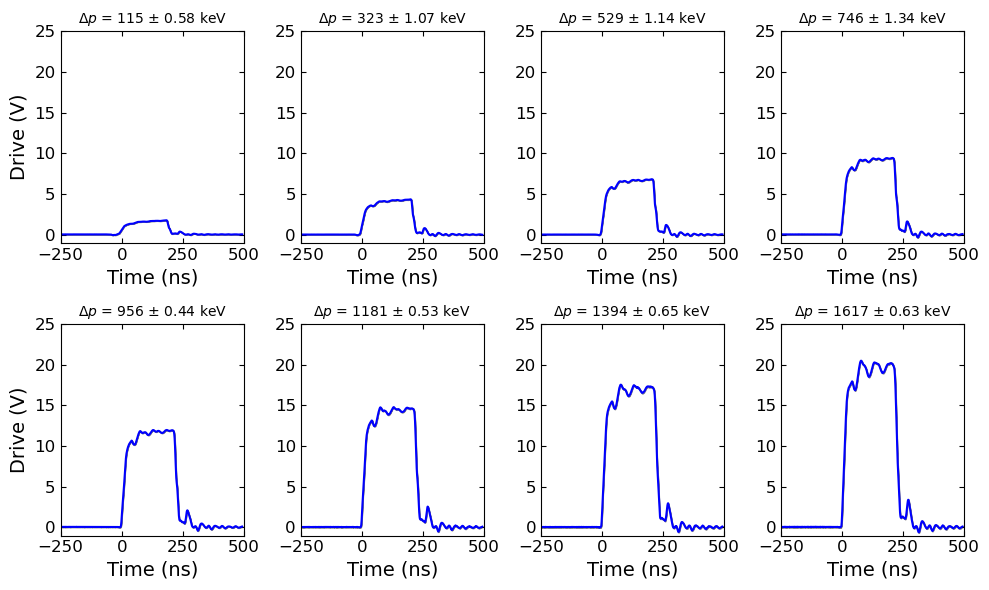

In [26]:
charge = 10
efield = 128 # V/m

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i in range(8):
    ax = axes.flatten()[i]

    amp_kev = charge * aas_mean[i] * 128 * 1.602e-19 * utils.SI2ev / 1000
    amp_kev_std = charge * aas_std[i] * 128 * 1.602e-19 * utils.SI2ev / 1000
    
    ax.fill_between(tt*1e9, dds_mean[i]-dds_std[i], dds_mean[i]+dds_std[i], color='grey', alpha=0.95)
    ax.plot(tt*1e9, dds_mean[i], color='blue')
    
    ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)

    ax.set_xlim(-250, 500)
    ax.set_ylim(-1, 25)
    
    if i == 0 or i == 4:
        ax.set_ylabel('Drive (V)')

    ax.set_xlabel('Time (ns)')

fig.tight_layout()

In [29]:
folder = r'/Volumes/LaCie/pulse_calibration/sphere_20241221/20241222_10e_alignment0_5e-8mbar'
datasets = [f'20241222_dg_10e_200ns_{v}v' for v in ['2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']]
pulseamps = np.asarray([115, 323, 529, 746, 956, 1181, 1394, 1617])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241222_dg_10e_200ns_2.5v
20241222_dg_10e_200ns_5v
20241222_dg_10e_200ns_7.5v
20241222_dg_10e_200ns_10v
20241222_dg_10e_200ns_12.5v
20241222_dg_10e_200ns_15v
20241222_dg_10e_200ns_17.5v
20241222_dg_10e_200ns_20v


(0.0, 2500.0)

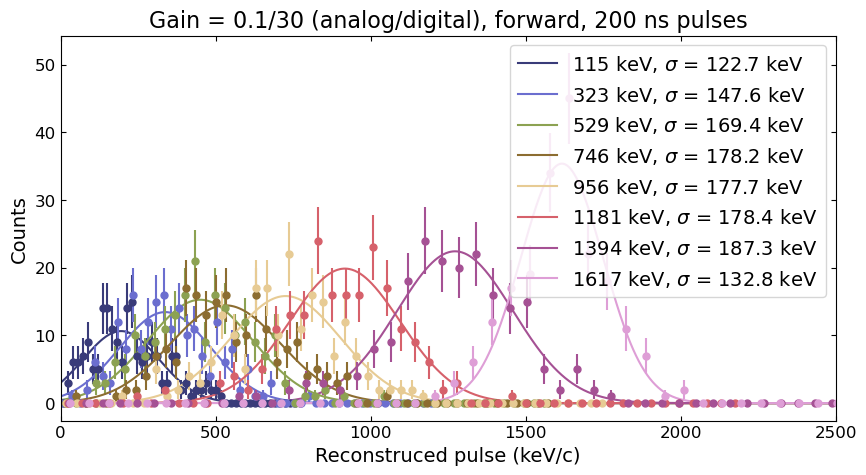

In [30]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [31]:
folder = r'/Volumes/LaCie/pulse_calibration/sphere_20241221/20241222_10e_alignment0_5e-8mbar_1'
datasets = [f'20241222_dg_10e_200ns_{v}v' for v in ['2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']]
pulseamps = np.asarray([115, 323, 529, 746, 956, 1181, 1394, 1617])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20241222_dg_10e_200ns_2.5v
20241222_dg_10e_200ns_5v
20241222_dg_10e_200ns_7.5v
20241222_dg_10e_200ns_10v
20241222_dg_10e_200ns_12.5v
20241222_dg_10e_200ns_15v
20241222_dg_10e_200ns_17.5v
20241222_dg_10e_200ns_20v


(0.0, 2500.0)

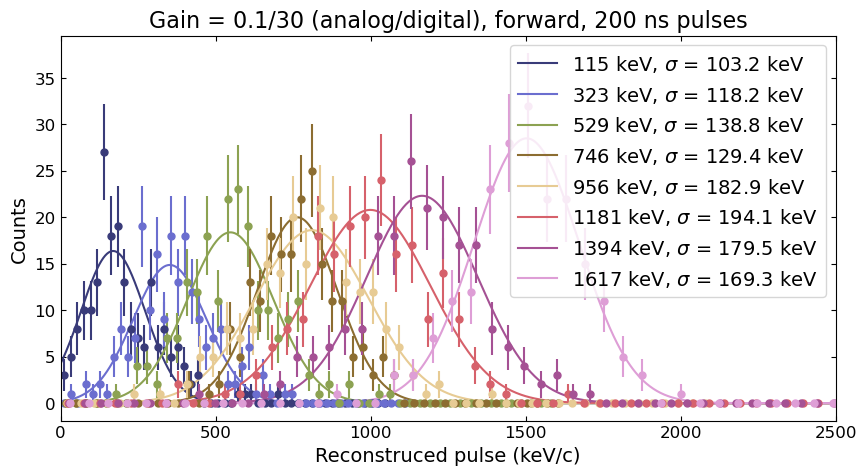

In [32]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev_1 = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [34]:
amp2kev_1

6844.611961407297

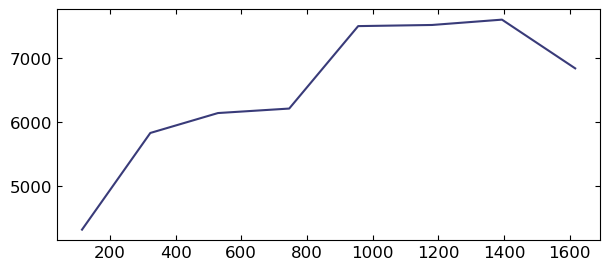

In [35]:
plt.plot(pulseamps, amp2kevs)